### 0.0. Dependencies and Data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import math 
import rfpimp

In [2]:
retail_areas = pd.read_csv("retail_areas_final.csv")

In [3]:
print(retail_areas.dtypes)

date                                                       object
id                                                        float64
events                                                    float64
weekend                                                      bool
season                                                     object
holiday                                                      bool
Local Footprint Name                                       object
Region                                                     object
Base Score                                                float64
Retail Footprint Score                                    float64
Residential Population (Weighted Catchment)               float64
Spend Per Head (Residential)                              float64
Sparsity                                                   object
Longitude                                                 float64
Latitude                                                  float64
Tourism Sc

In [4]:
print("Number of unique Local_Footprint_Centre_ID:", retail_areas['Local_Footprint_Centre_ID'].nunique())
print("Total number of rows:", len(retail_areas))

Number of unique Local_Footprint_Centre_ID: 1207
Total number of rows: 437686


In [5]:
unique_days = retail_areas.loc[retail_areas['mean_wind'].isna(), 'date'].unique()
unique_days_sorted = sorted(unique_days)
print("Unique days with missing mean_wind:", unique_days_sorted)

Unique days with missing mean_wind: ['2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05', '2024-01-06', '2024-01-07', '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14', '2024-01-25', '2024-02-09', '2024-03-01', '2024-03-02', '2024-03-03', '2024-03-04', '2024-03-07', '2024-03-08', '2024-03-09', '2024-03-10', '2024-03-11', '2024-04-02', '2024-04-03', '2024-04-04', '2024-04-23', '2024-05-15', '2024-05-16', '2024-05-17', '2024-05-18', '2024-05-19', '2024-06-14', '2024-06-15', '2024-06-16', '2024-06-17', '2024-06-21', '2024-06-22', '2024-06-23', '2024-06-24', '2024-06-25', '2024-06-26', '2024-06-27', '2024-06-28', '2024-07-05', '2024-07-06', '2024-07-07', '2024-08-05', '2024-08-13', '2024-08-14', '2024-08-15', '2024-08-16', '2024-08-17', '2024-08-18', '2024-08-19', '2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31', '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-11', '2024-10-07', '2024-10-12', '2024-10-13', '2024-10-30

### 1.1. Model Prep

#### 1.1.1. Check for linear relationships

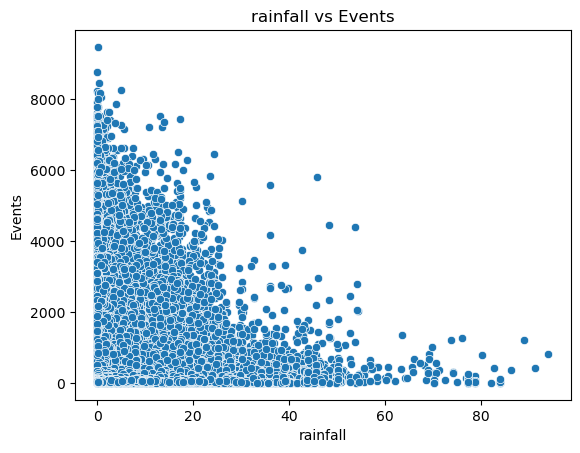

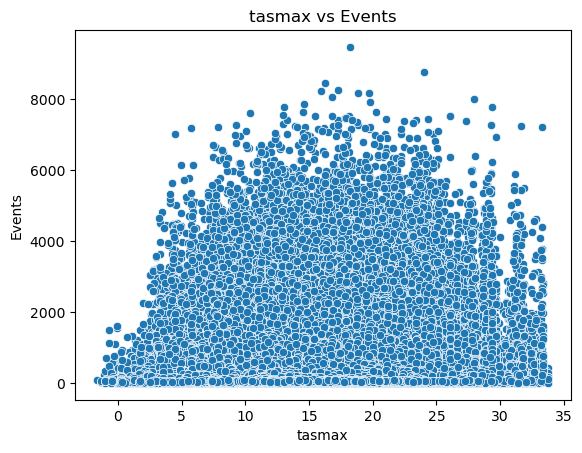

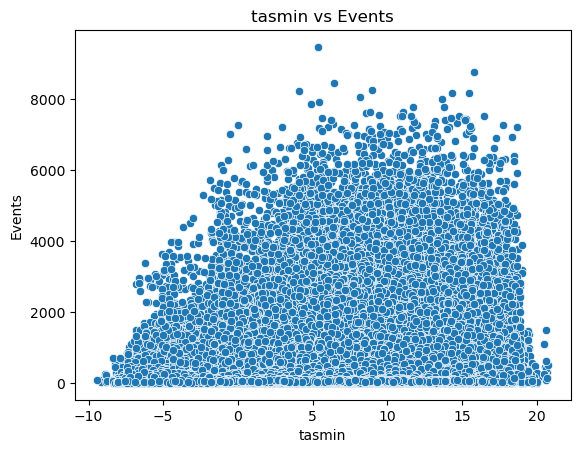

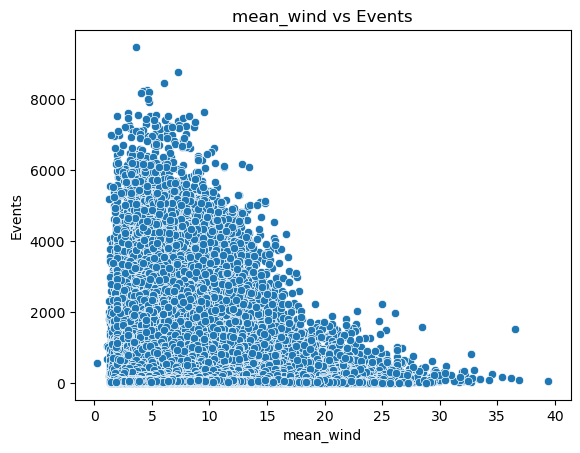

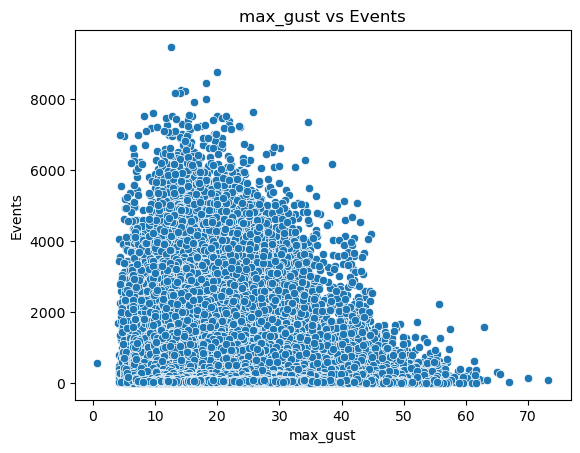

In [6]:
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']

for var in weather_vars:
    sns.scatterplot(x=var, y='events', data=retail_areas)
    plt.title(f'{var} vs Events')
    plt.xlabel(var)
    plt.ylabel('Events')
    plt.show()

#### 1.1.2. Variable encoding

In [7]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


### 2.1. General Model

#### 2.1.1. Most basic

In [8]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'weekend',
    'holiday',
    ] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [9]:
print(df_model.groupby('date')['id'].nunique())

date
2024-01-15    1175
2024-01-16    1179
2024-01-17    1172
2024-01-18    1178
2024-01-19    1180
              ... 
2024-11-20    1183
2024-11-25    1184
2024-11-26    1181
2024-11-27    1186
2024-12-02    1183
Name: id, Length: 255, dtype: int64


Hyperparameters:

In [10]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END .................max_depth=10, min_samples_split=10; total time=   9.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  12.0s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  12.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  12.7s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  12.2s
[CV] END .................max_depth=10, min_samples_split=10; total time=  12.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  13.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  13.3s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  13.2s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  13.1s
[CV] END .................max_depth=10, min_samples_split=10; total time=  13.0s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  13.3s
[CV] END ..................m

Implement random forest:

In [11]:
rf_final = RandomForestRegressor(**clf.best_params_, 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,40
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [12]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.8070 ± 0.0011
Mean Train RMSE: 275.2352 ± 0.5515
Mean Test R²: 0.7955 ± 0.0046
Mean Test RMSE: 283.3034 ± 2.2917


Feature importance:

                                             Importance
Feature                                                
Residential Population (Weighted Catchment)    1.618759
season_Spring                                  0.036791
season_Winter                                  0.033772
weekend                                        0.010475
season_Summer                                  0.007990
holiday                                        0.000625


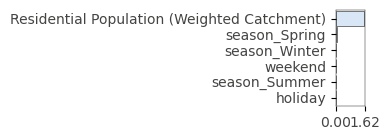

In [13]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.2. Add CACI scores

Train/test:

In [14]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')]

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [15]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.1s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  20.4s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  21.2s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  21.4s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  21.3s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  21.3s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  21.4s
[CV] END .................max_depth=10, min_samples_split=10; total time=  21.5s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  21.9s
[CV] END .................max_depth=10, min_sam

Implement random forest:

In [16]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validate model performance:

In [17]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_final,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9426 ± 0.0003
Mean Train RMSE: 150.0538 ± 0.2764
Mean Test R²: 0.9353 ± 0.0013
Mean Test RMSE: 159.3801 ± 1.0760


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.151594
Retail Footprint Score                         0.783566
Tourism Score                                  0.624904
Residential Population (Weighted Catchment)    0.447202
season_Winter                                  0.041173
season_Spring                                  0.028724
weekend                                        0.014428
season_Summer                                  0.009155
holiday                                        0.000332


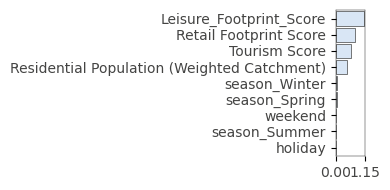

In [18]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.3. Add weather

Train/test:

In [19]:
# define target and features
target = 'events'
weather_vars = ['rainfall', 'tasmax', 'mean_wind']

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Leisure_Footprint_Score',
    'Retail Footprint Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + weather_vars

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [20]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.0min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.0min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.0min
[CV] END ..................m

Implement random forest:

In [21]:
rf_general_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_general_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [22]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_general_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9698 ± 0.0002
Mean Train RMSE: 108.8295 ± 0.3080
Mean Test R²: 0.9329 ± 0.0012
Mean Test RMSE: 162.2635 ± 0.9817


Feature importance:

                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.226577
Retail Footprint Score                         0.937479
Tourism Score                                  0.598352
Residential Population (Weighted Catchment)    0.579940
season_Spring                                  0.040697
season_Winter                                  0.027930
weekend                                        0.013377
tasmax                                         0.012077
mean_wind                                      0.006488
season_Summer                                  0.003893
holiday                                        0.001823
rainfall                                       0.001313


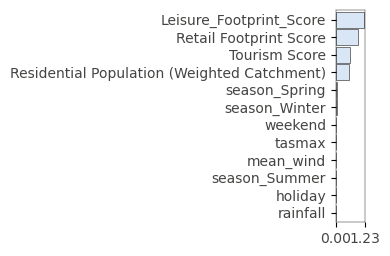

In [23]:
imp = rfpimp.importances(rf_general_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.4. Extreme Weather

In [24]:
# define target and features
target = 'events'

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [25]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END .................max_depth=10, min_samples_split=10; total time=  18.7s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.8s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  20.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  24.8s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  23.2s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  22.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  23.4s
[CV] END .................max_depth=10, min_samples_split=10; total time=  23.6s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.0s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.2s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  25.2s
[CV] END ..................m

In [26]:
rf_extreme_weather = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_extreme_weather.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [27]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_extreme_weather,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9431 ± 0.0003
Mean Train RMSE: 149.4686 ± 0.3054
Mean Test R²: 0.9351 ± 0.0013
Mean Test RMSE: 159.6424 ± 1.0928


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.201546
Retail Footprint Score                         0.807052
Tourism Score                                  0.599545
Residential Population (Weighted Catchment)    0.485779
season_Spring                                  0.037349
season_Winter                                  0.033714
weekend                                        0.018753
season_Summer                                  0.010456
holiday                                        0.002616
extreme_rain                                   0.000135
high_wind                                     -0.000015
extreme_heat                                  -0.000223


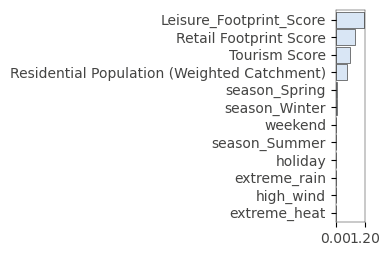

In [28]:
imp = rfpimp.importances(rf_extreme_weather, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 2.1.5. Add retail type

Get retail type dummies:

In [29]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName', 'supergroupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


Train/test:

In [30]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_') or col.startswith('groupName_')] + weather_vars

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [31]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.1min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.1min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.2min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.2min
[CV] END ..................m

Implement random forest:

In [32]:
rf_retail = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_retail.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [33]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained rf_retail model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_retail,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_r2 = np.mean(cv_results['test_r2'])
std_r2 = np.std(cv_results['test_r2'])

mean_rmse = -np.mean(cv_results['test_rmse'])  # negate because it's negative by default
std_rmse = np.std(cv_results['test_rmse'])

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9695 ± 0.0002
Mean Train RMSE: 109.4094 ± 0.3733
Mean Test R²: 0.9334 ± 0.0012
Mean Test RMSE: 161.6955 ± 0.9903


Feature importance:

                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.152703
Tourism Score                                         0.398669
Retail Footprint Score                                0.369810
groupName_Indie high streets                          0.275960
Residential Population (Weighted Catchment)           0.149341
season_Winter                                         0.033285
groupName_Secondary retail parks and shopping c...    0.027587
season_Spring                                         0.027562
groupName_Local urban convenience centres             0.022751
weekend                                               0.014337
tasmax                                                0.007982
groupName_Mass and value high streets                 0.003360
mean_wind                                             0.003214
season_Summer                                         0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


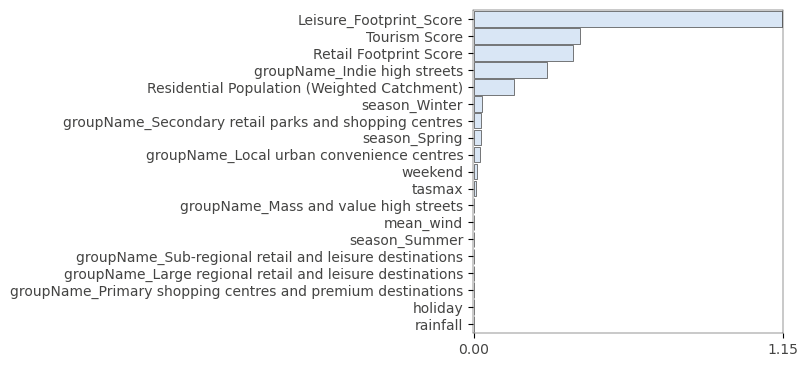

In [34]:
imp = rfpimp.importances(rf_retail, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plot:

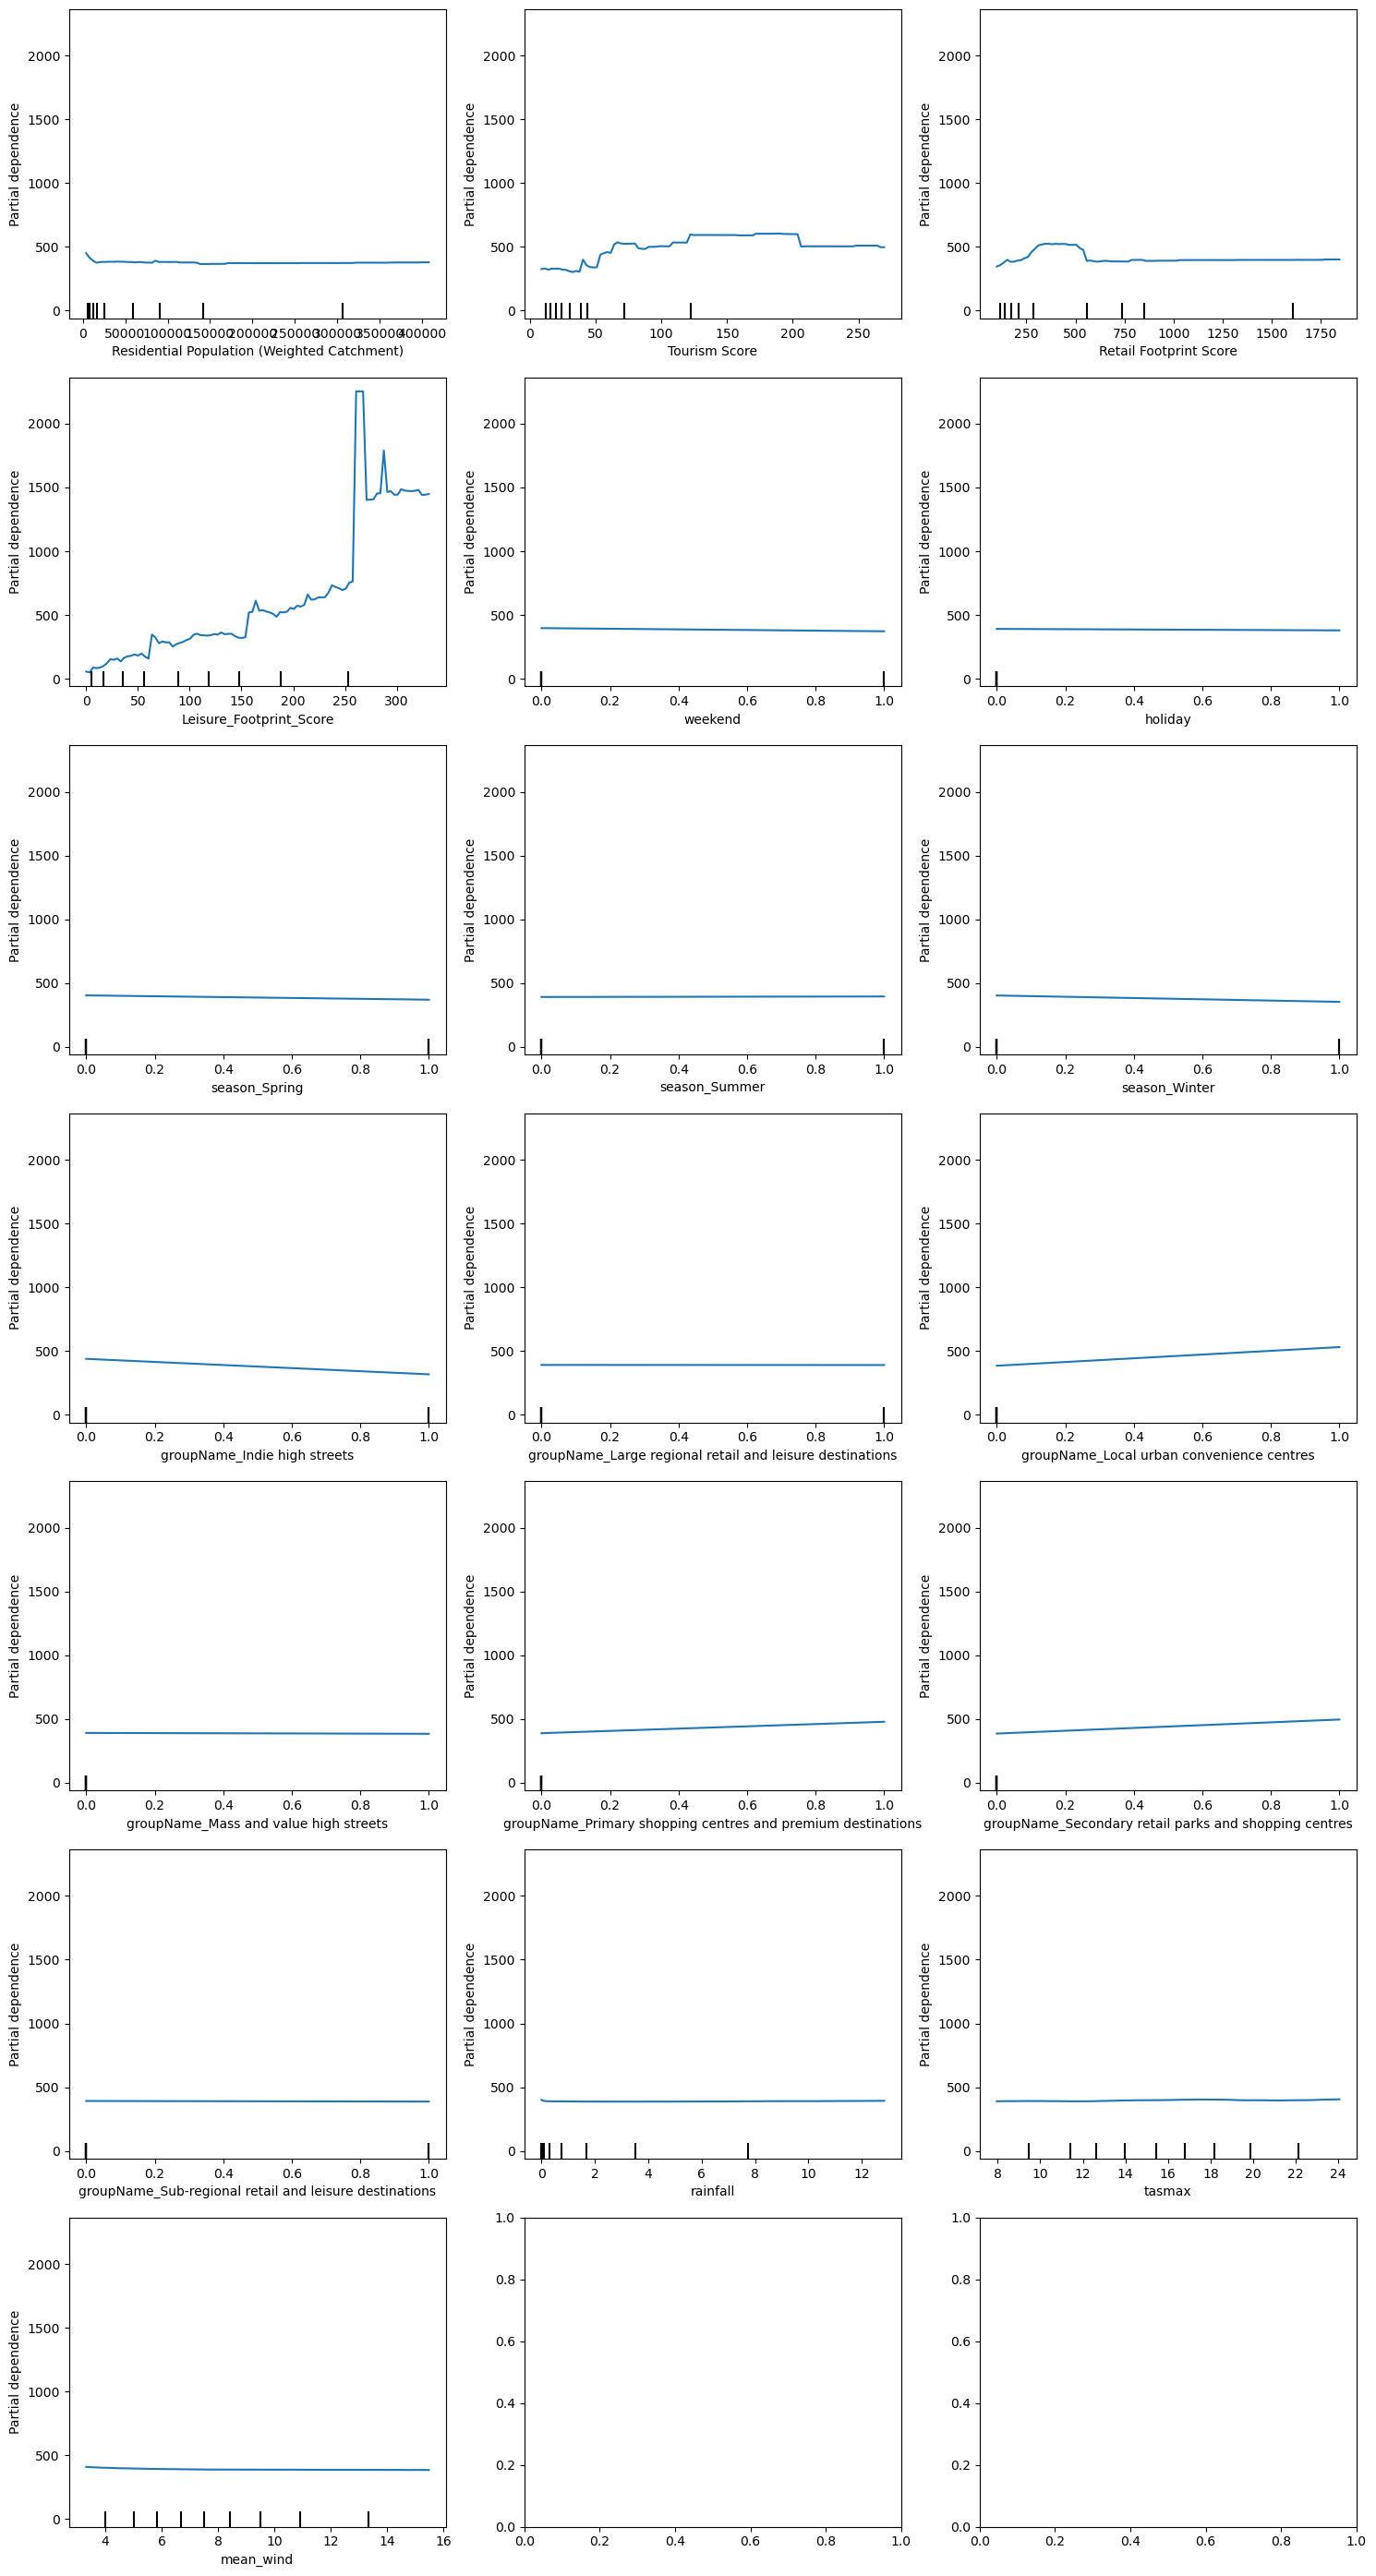

In [35]:
from sklearn.inspection import PartialDependenceDisplay

# plot partial dependence for all features in train_x
features = train_x.columns.tolist() 

# create grid layout
n_features = len(features)
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()

# plot
PartialDependenceDisplay.from_estimator(
    rf_retail,
    train_x,
    features=features,
    ax=ax[:n_features]  # ensure ax isn't longer than the number of features
)

plt.tight_layout()
plt.show()

#### 2.1.5. Add retail type (extreme weather)

Get retail type dummies:

In [36]:
# copy to avoid modifying original
df_model = retail_areas.copy()

# drop unnecessary columns
df_model = df_model.drop(['Minor_Class_Name', 'Major_Class_Name', 'Seasonality_Class_Name'], axis=1)

# one-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region', 'groupName', 'supergroupName']
df_model = pd.get_dummies(df_model, columns=cat_vars, drop_first=True)

# extreme weather dummies
df_model['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

# drop missing values
print(df_model.isnull().sum()[df_model.isnull().sum() > 0])
num_rows_with_missing = df_model.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model)}")
df_model = df_model.dropna()
print(f"Total rows after drop: {len(df_model)}")

Tourism Score       680
rainfall           3976
tasmax             3976
tasmin             3976
mean_wind        132578
max_gust         132578
dtype: int64
Rows with at least one missing value: 135831
Total rows before drop: 437686
Total rows after drop: 301855


Train/test:

In [37]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns if col.startswith('season_') or col.startswith('groupName_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

Hyperparameters:

In [38]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[CV] END ..................max_depth=10, min_samples_split=4; total time=  25.0s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  27.7s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  28.1s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  28.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  28.5s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  28.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  29.3s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  29.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  31.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  29.4s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  30.8s
[CV] END .................max_depth=10, min_samples_split=10; total time=  29.6s
[CV] END ..................m

Implement random forest:

In [39]:
rf_retail2 = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_retail2.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Cross-validated performance:

In [40]:
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.metrics import make_scorer

# define the cross-validation strategy: 5 folds, 3 repetitions
cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# use the trained rf_retail2 model from tuned GridSearchCV
# evaluate using R² and RMSE
cv_results = cross_validate(
    rf_retail2,
    train_x, train_y,
    cv=cv_strategy,
    scoring={
        'r2': 'r2',
        'rmse': 'neg_root_mean_squared_error'
    },
    return_train_score=True,
    n_jobs=-1,
    verbose=0
)

# extract and print mean + std for each metric
mean_r2 = np.mean(cv_results['test_r2'])
std_r2 = np.std(cv_results['test_r2'])

mean_rmse = -np.mean(cv_results['test_rmse'])  # negate because it's negative by default
std_rmse = np.std(cv_results['test_rmse'])

# extract and print mean + std for each metric
mean_test_r2 = np.mean(cv_results['test_r2'])
std_test_r2 = np.std(cv_results['test_r2'])

mean_test_rmse = -np.mean(cv_results['test_rmse'])
std_test_rmse = np.std(cv_results['test_rmse'])

# extract mean and std for train metrics
mean_train_r2 = np.mean(cv_results['train_r2'])
std_train_r2 = np.std(cv_results['train_r2'])

mean_train_rmse = -np.mean(cv_results['train_rmse'])
std_train_rmse = np.std(cv_results['train_rmse'])

# print results
print(f"Repeated CV Results (Random Forest with tuned hyperparameters):")
print(f"Mean Train R²: {mean_train_r2:.4f} ± {std_train_r2:.4f}")
print(f"Mean Train RMSE: {mean_train_rmse:.4f} ± {std_train_rmse:.4f}")
print(f"Mean Test R²: {mean_test_r2:.4f} ± {std_test_r2:.4f}")
print(f"Mean Test RMSE: {mean_test_rmse:.4f} ± {std_test_rmse:.4f}")

Repeated CV Results (Random Forest with tuned hyperparameters):
Mean Train R²: 0.9436 ± 0.0003
Mean Train RMSE: 148.8016 ± 0.2780
Mean Test R²: 0.9352 ± 0.0013
Mean Test RMSE: 159.4182 ± 1.0971


Feature importance:

                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.138384
Retail Footprint Score                                0.436670
Tourism Score                                         0.397708
groupName_Indie high streets                          0.259284
Residential Population (Weighted Catchment)           0.149757
season_Spring                                         0.037041
groupName_Secondary retail parks and shopping c...    0.035306
season_Winter                                         0.035161
groupName_Local urban convenience centres             0.023154
weekend                                               0.012959
season_Summer                                         0.009931
groupName_Mass and value high streets                 0.003358
holiday                                               0.002818
groupName_Sub-regional retail and leisure desti...    0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


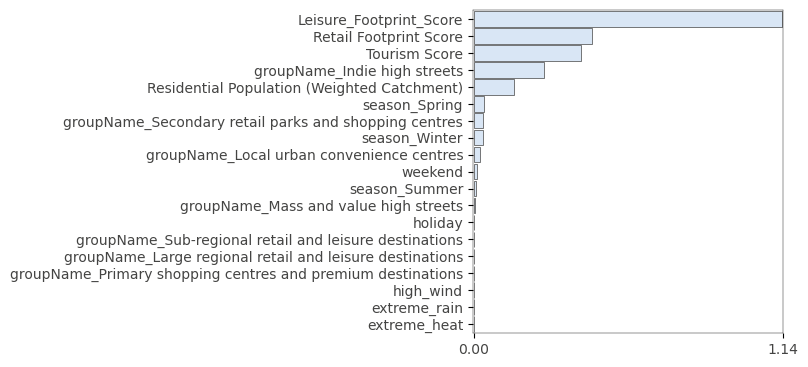

In [41]:
imp = rfpimp.importances(rf_retail2, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

Partial dependence plot:

/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 16 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 17 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(
/workspace/.conda/lib/python3.11/site-packages/sklearn/inspection/_partial_depende

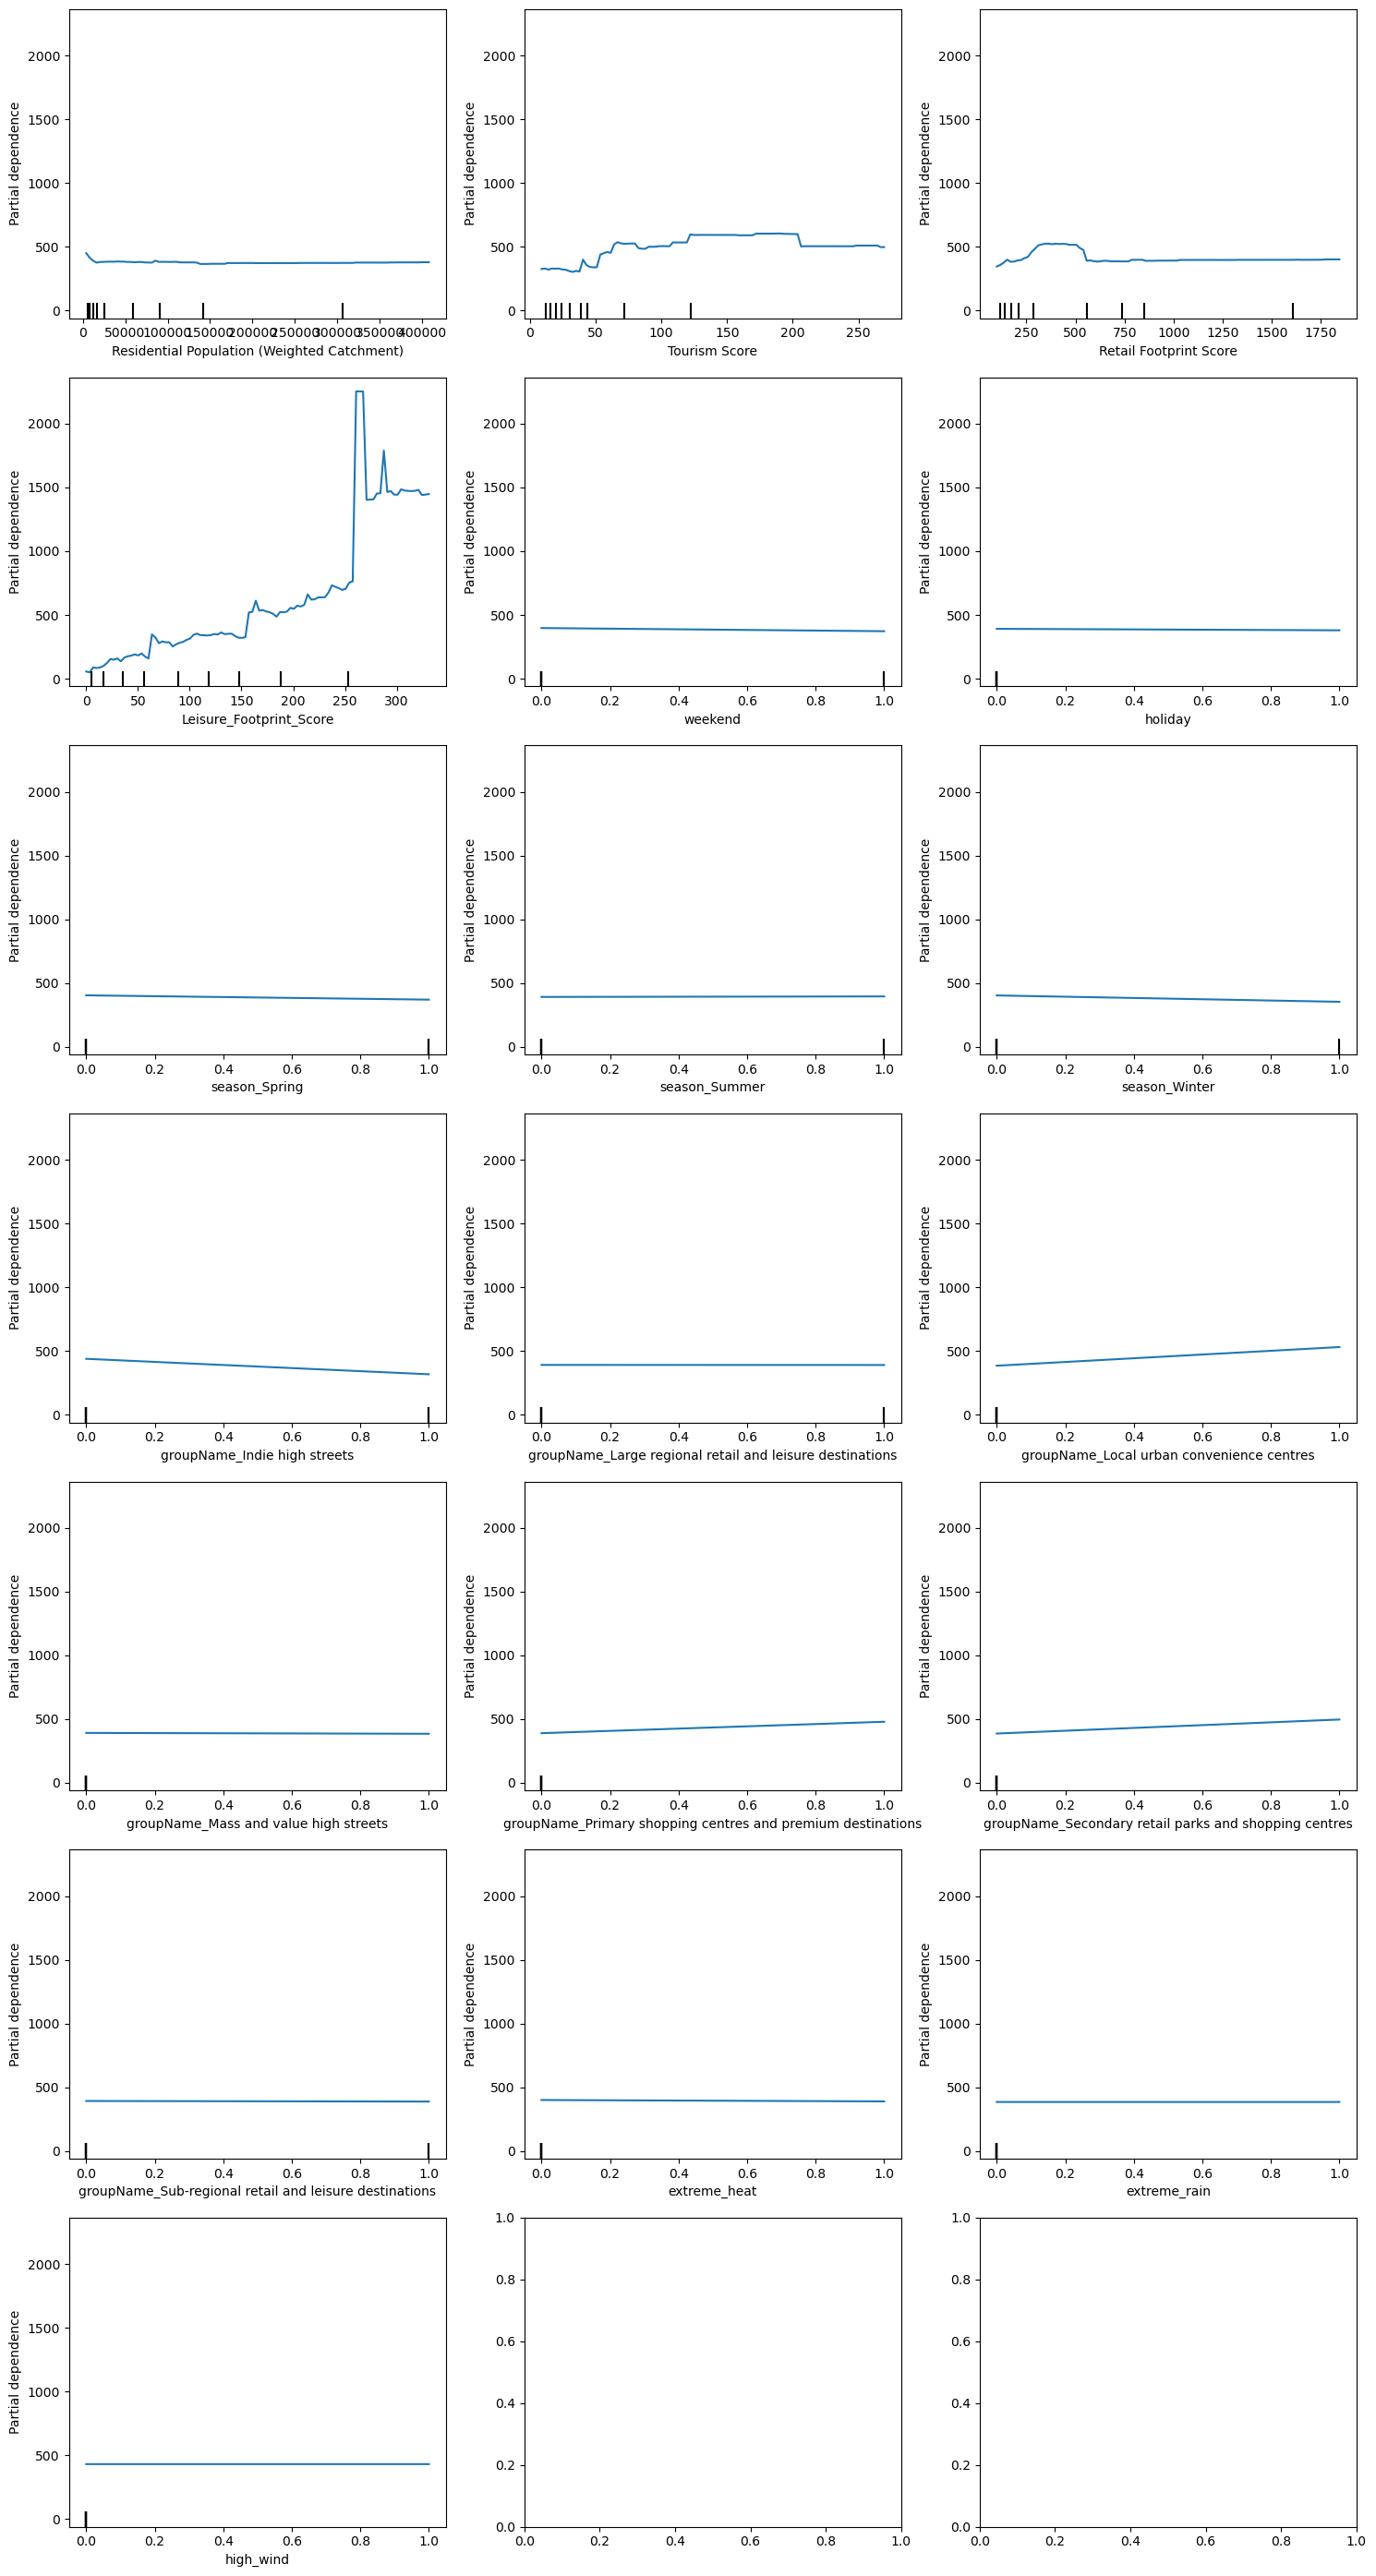

In [42]:
from sklearn.inspection import PartialDependenceDisplay

# plot partial dependence for all features in train_x
features = train_x.columns.tolist() 

# create grid layout
n_features = len(features)
n_cols = 3
n_rows = -(-n_features // n_cols)  # ceiling division

fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
ax = ax.flatten()

# plot
PartialDependenceDisplay.from_estimator(
    rf_retail,
    train_x,
    features=features,
    ax=ax[:n_features]  # ensure ax isn't longer than the number of features
)

plt.tight_layout()
plt.show()

### 2.2. Model per retail type

#### 2.2.1. Without weather

In [56]:
# copy to avoid modifying original
df_model2 = retail_areas.copy()

df_model2 = df_model2.drop(['Minor_Class_Name', 'Major_Class_Name'], axis=1)

# One-hot encode categorical variables
cat_vars = ['season', 'Sparsity', 'Region']
            #'supergroupName', 'groupName']
df_model2 = pd.get_dummies(df_model2, columns=cat_vars, drop_first=True)

# extreme weather dummies
df_model2['extreme_heat'] = (df_model['tasmax'] > 30).astype(int)
df_model2['extreme_rain'] = (df_model['rainfall'] > 25).astype(int)
df_model2['high_wind'] = (df_model['mean_wind'] > 20).astype(int)

print(df_model2.isnull().sum())
num_rows_with_missing = df_model2.isnull().any(axis=1).sum()
print(f"Rows with at least one missing value: {num_rows_with_missing}")
print(f"Total rows before drop: {len(df_model2)}")
df_model2 = df_model2.dropna()
print(f"Total rows after drop: {len(df_model2)}")

date                                    0
id                                      0
events                                  0
weekend                                 0
holiday                                 0
                                    ...  
Region_West Midlands                    0
Region_Yorkshire and The Humber         0
extreme_heat                       135831
extreme_rain                       135831
high_wind                          135831
Length: 74, dtype: int64
Rows with at least one missing value: 136340
Total rows before drop: 437686
Total rows after drop: 301346


Model:

In [44]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model2.columns if col.startswith('season_')]

Add calibration:

In [45]:
# loop over groups
for name, group_data in df_model2.groupby(group_col):
    if len(group_data) < 30:
        continue  # Skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.956


/workspace/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Repeated CV (15-fold):
Train R²: 0.960 ± 0.000
Train RMSE: 190.313 ± 0.898
Test R²: 0.956 ± 0.002
Test RMSE: 199.933 ± 3.706
Feature Importances:
Leisure_Footprint_Score                        0.437
Tourism Score                                  0.317
Retail Footprint Score                         0.113
Residential Population (Weighted Catchment)    0.097
season_Winter                                  0.013
season_Spring                                  0.012
weekend                                        0.006
season_Summer                                  0.004
holiday                                        0.001
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.85
Repeated CV (15-fold):
Train R²: 0.868 ± 0.001
Train RMSE: 152.467 ± 0.589
Test R²: 0.854 ± 0.004
Test RMSE: 160.139 ± 2.448
Feature Importances:
Leisure_Footprint_Score                        0.477
Tourism Score                                  0.170


#### 2.2.2. With weather

In [46]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'Tourism Score',
    'weekend',
    'holiday',
] + [col for col in df_model2.columns if col.startswith('season_')] + weather_vars

Calibrated and cross-validated:

In [47]:
# loop over groups
for name, group_data in df_model2.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))


Group: District urban service centres
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.955
Repeated CV (15-fold):
Train R²: 0.982 ± 0.000
Train RMSE: 126.736 ± 0.557
Test R²: 0.955 ± 0.001
Test RMSE: 202.098 ± 3.068
Feature Importances:
Leisure_Footprint_Score                        0.429
Tourism Score                                  0.309
Retail Footprint Score                         0.113
Residential Population (Weighted Catchment)    0.089
tasmax                                         0.012
season_Winter                                  0.012
season_Spring                                  0.011
mean_wind                                      0.009
rainfall                                       0.007
weekend                                        0.006
season_Summer                                  0.002
holiday                                        0.001
dtype: float64

Group: Indie high streets
Best parameters: {'max_depth': 20, 'min_samples_split

/workspace/.conda/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Repeated CV (15-fold):
Train R²: 0.903 ± 0.002
Train RMSE: 129.980 ± 1.244
Test R²: 0.847 ± 0.012
Test RMSE: 163.224 ± 5.839
Feature Importances:
Retail Footprint Score                         0.482
Tourism Score                                  0.192
Leisure_Footprint_Score                        0.156
Residential Population (Weighted Catchment)    0.040
season_Winter                                  0.031
season_Spring                                  0.029
tasmax                                         0.024
mean_wind                                      0.020
rainfall                                       0.012
weekend                                        0.009
season_Summer                                  0.003
holiday                                        0.001
dtype: float64

Group: Sub-regional retail and leisure destinations
Best parameters: {'max_depth': 20, 'min_samples_split': 10}
Best CV R² score: 0.955
Repeated CV (15-fold):
Train R²: 0.982 ± 0.000
Train RMSE: 102.410

Partial dependence plots:

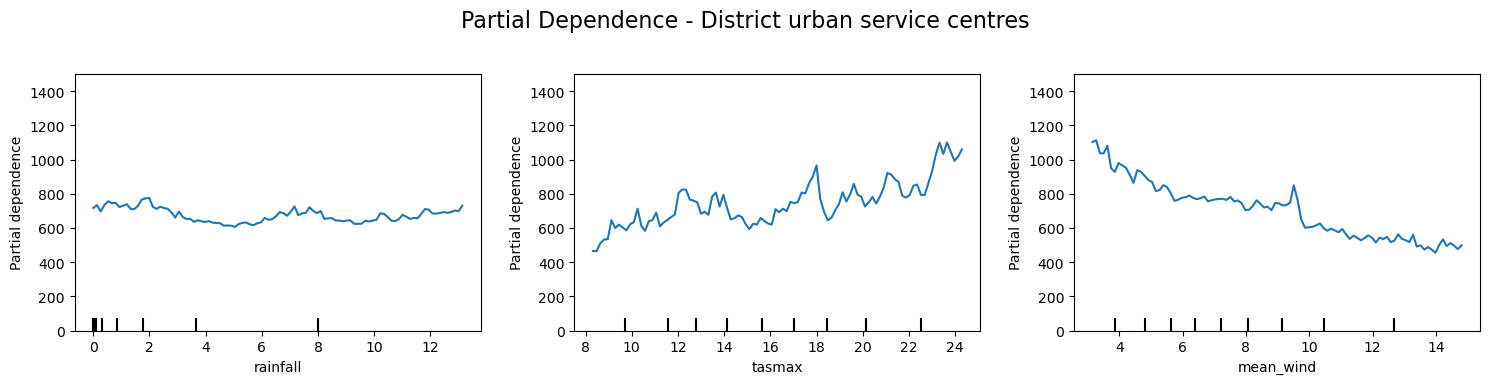

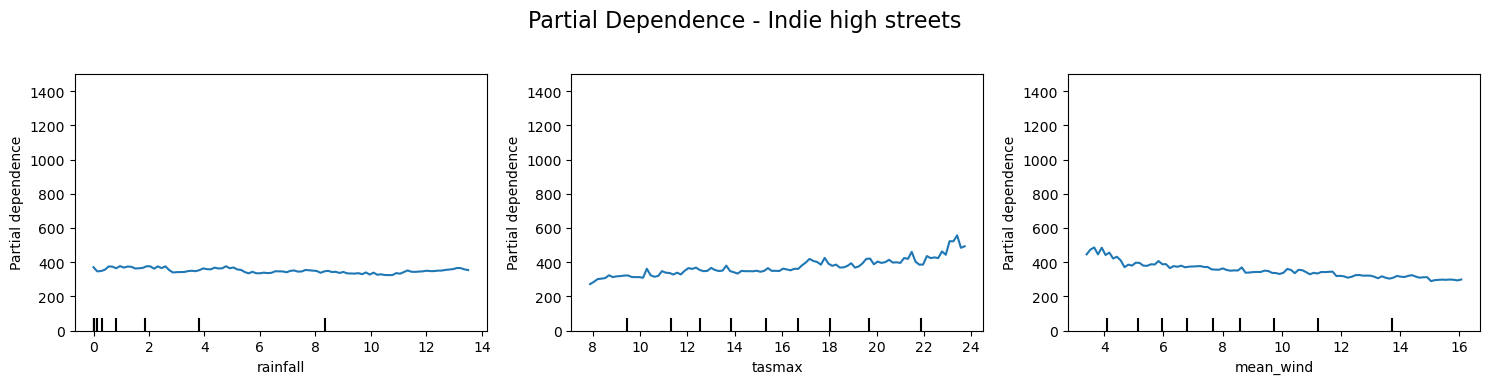

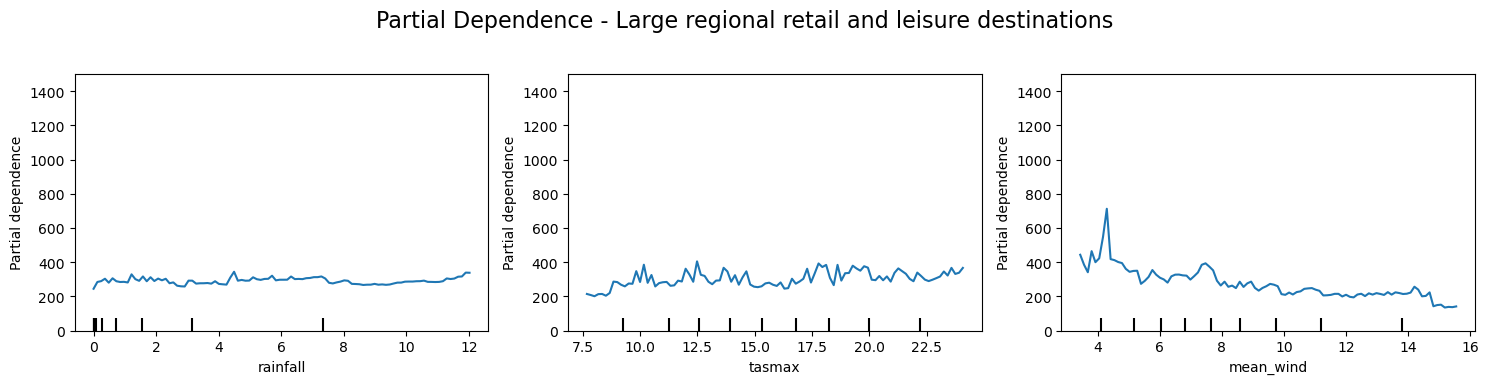

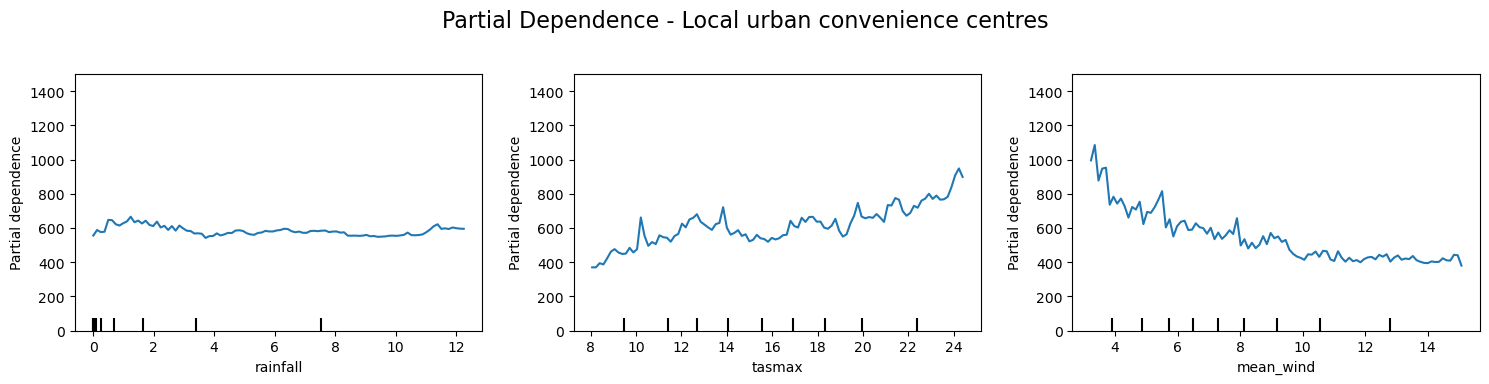

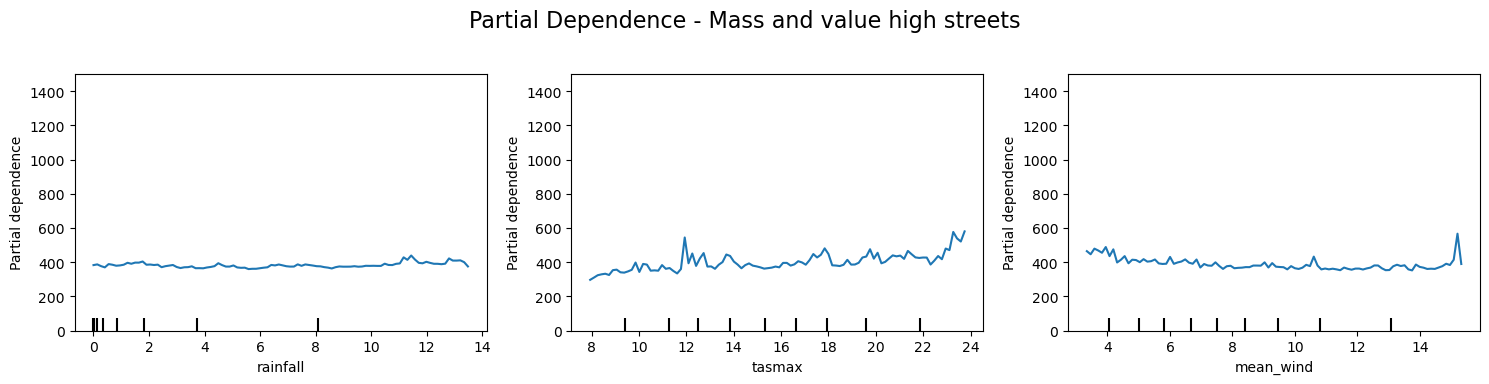

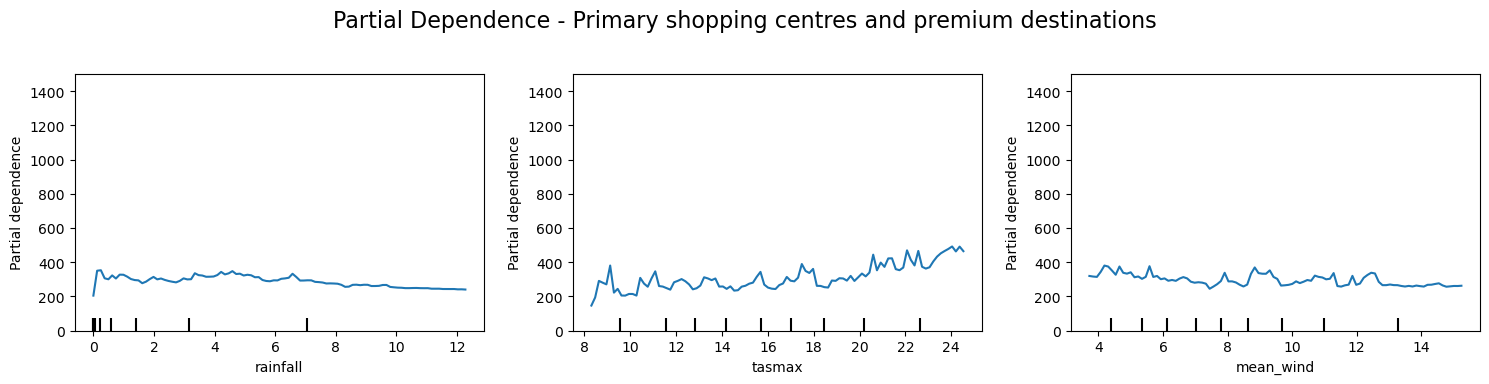

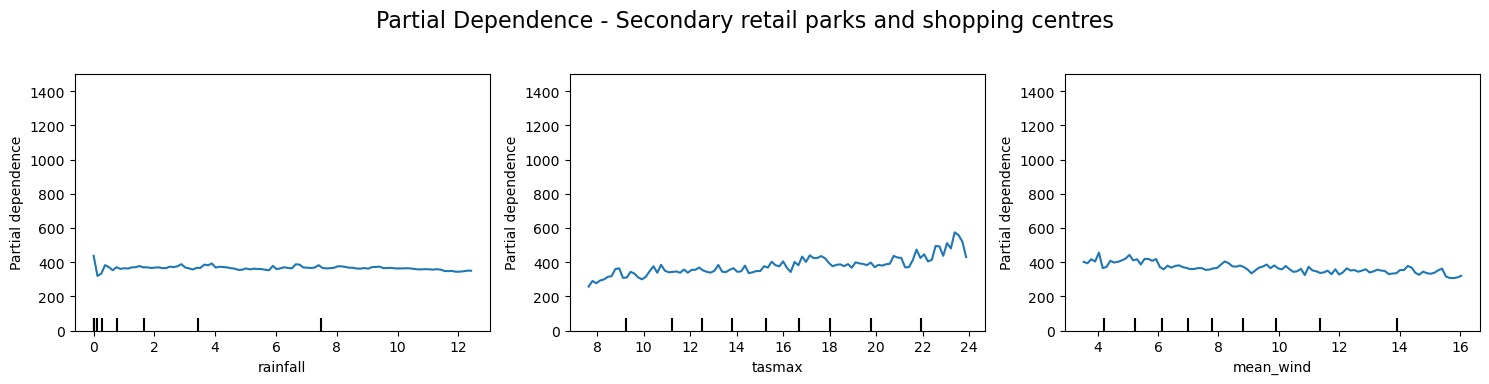

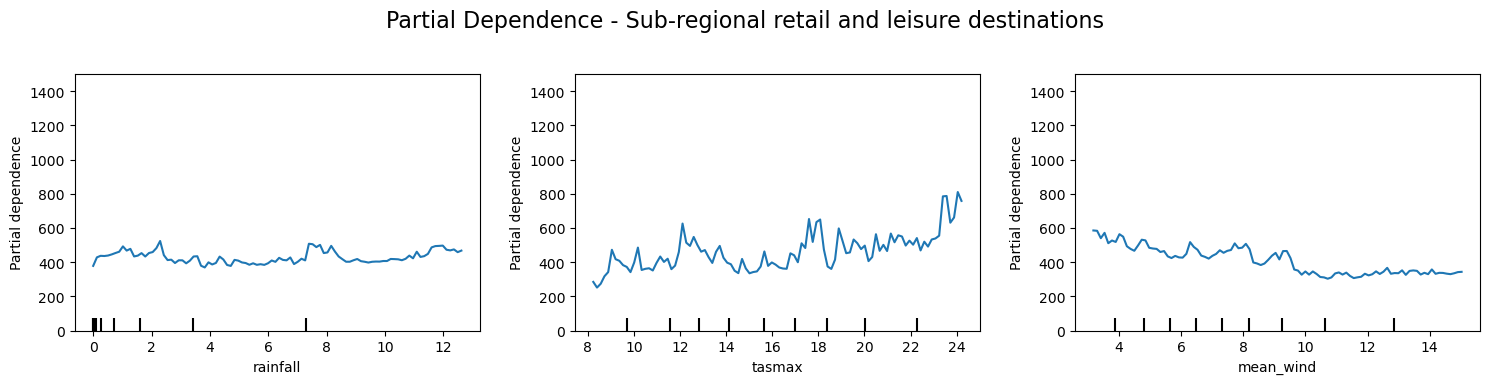

In [48]:
for name, group_data in df_model2.groupby('groupName'):
    if len(group_data) < 30:
        continue  # skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # handle missing values (robustness)
    X = X.fillna(X.median())

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### 2.2.2. Extreme weather

In [57]:
group_col = 'groupName'
randomState_dt = 10000

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
    'Tourism Score',
] + [col for col in df_model2.columns if col.startswith('season_')] + ['extreme_heat', 'extreme_rain', 'high_wind']

Calibrated and cross-validated:

In [ ]:
# loop over groups
for name, group_data in df_model2.groupby(group_col):
    if len(group_data) < 30:
        continue  # skip small groups

    # split train/test within each group
    train_x, test_x, train_y, test_y = train_test_split(
        group_data[features],
        group_data[target],
        test_size=0.2,
        random_state=randomState_dt
    )

    # hyperparameter tuning for this group
    rf = RandomForestRegressor(random_state=randomState_dt)
    hyperparameters = {'max_depth': [10, 20, 30, 40, 50],
                       'min_samples_split': [2, 4, 6, 8, 10]}
    
    clf = GridSearchCV(rf, hyperparameters, cv=5, n_jobs=1)
    clf.fit(train_x, train_y)

    print(f"\nGroup: {name}")
    print("Best parameters:", clf.best_params_)
    print("Best CV R² score:", round(clf.best_score_, 3))

    # fit tuned model on full group data (not just train_x/y)
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    )

    # repeated k-fold cross-validation
    cv_strategy = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)
    cv_results = cross_validate(
        model,
        group_data[features], group_data[target],
        cv=cv_strategy,
        scoring={
            'r2': 'r2',
            'rmse': 'neg_root_mean_squared_error'
        },
        return_train_score=True,
        n_jobs=-1
    )

    # summarize metrics
    mean_train_r2 = np.mean(cv_results['train_r2'])
    std_train_r2 = np.std(cv_results['train_r2'])

    mean_test_r2 = np.mean(cv_results['test_r2'])
    std_test_r2 = np.std(cv_results['test_r2'])

    mean_train_rmse = -np.mean(cv_results['train_rmse'])
    std_train_rmse = np.std(cv_results['train_rmse'])

    mean_test_rmse = -np.mean(cv_results['test_rmse'])
    std_test_rmse = np.std(cv_results['test_rmse'])

    print(f"Repeated CV (15-fold):")
    print(f"Train R²: {mean_train_r2:.3f} ± {std_train_r2:.3f}")
    print(f"Train RMSE: {mean_train_rmse:.3f} ± {std_train_rmse:.3f}")
    print(f"Test R²: {mean_test_r2:.3f} ± {std_test_r2:.3f}")
    print(f"Test RMSE: {mean_test_rmse:.3f} ± {std_test_rmse:.3f}")

    # fit final model for feature importances
    final_model = model.fit(train_x, train_y)
    importances = pd.Series(final_model.feature_importances_, index=features).sort_values(ascending=False)

    print("Feature Importances:")
    print(importances.round(3))

Partial dependence plots:

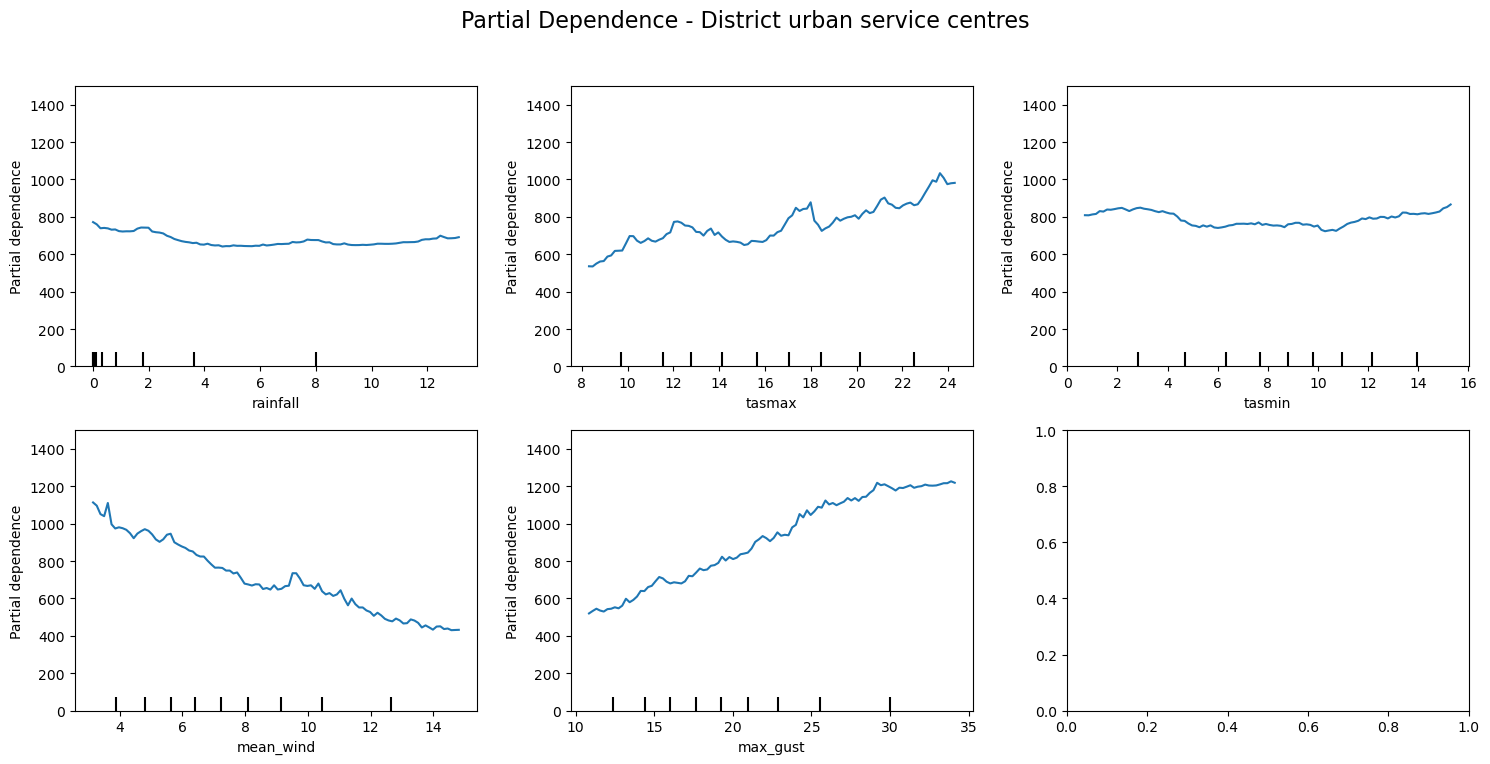

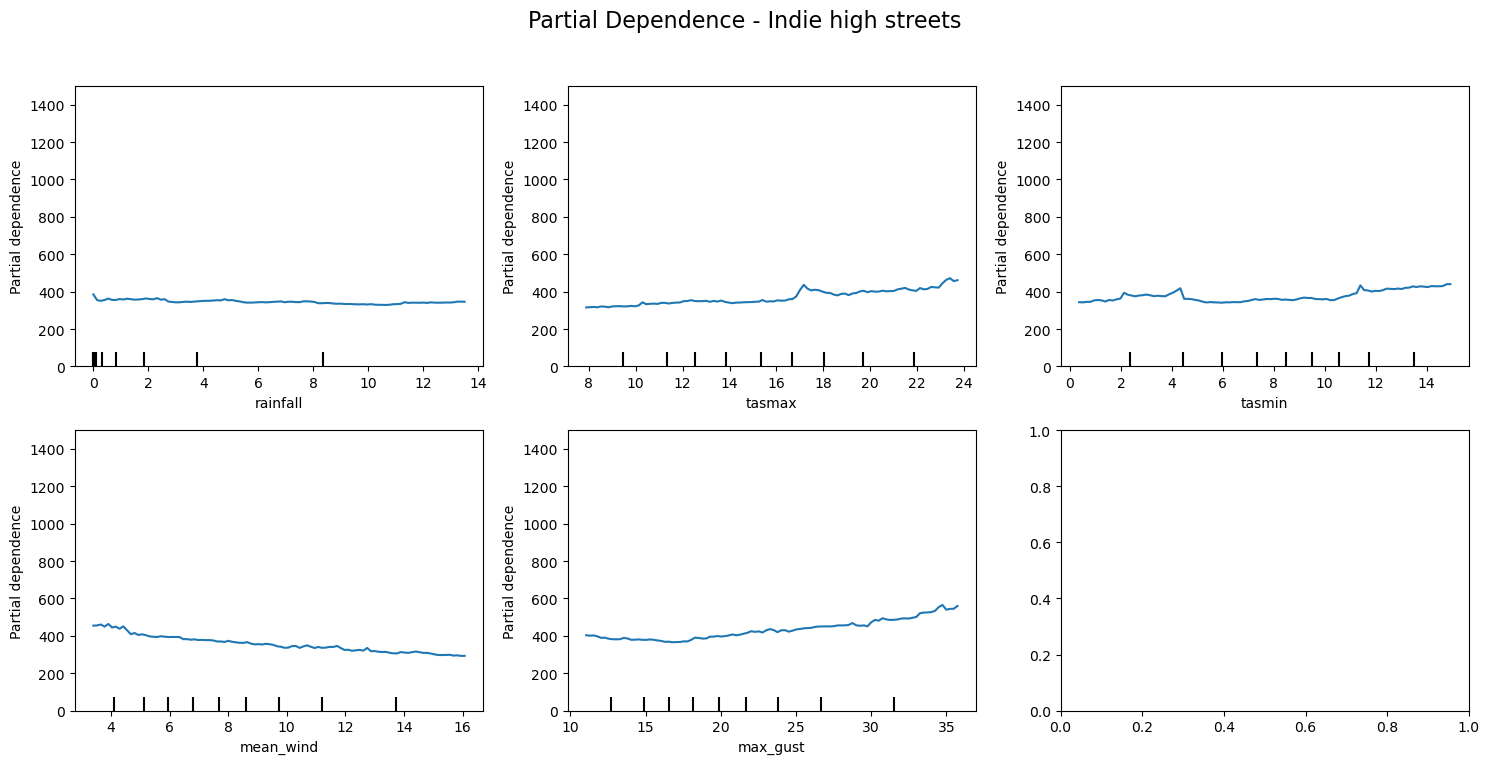

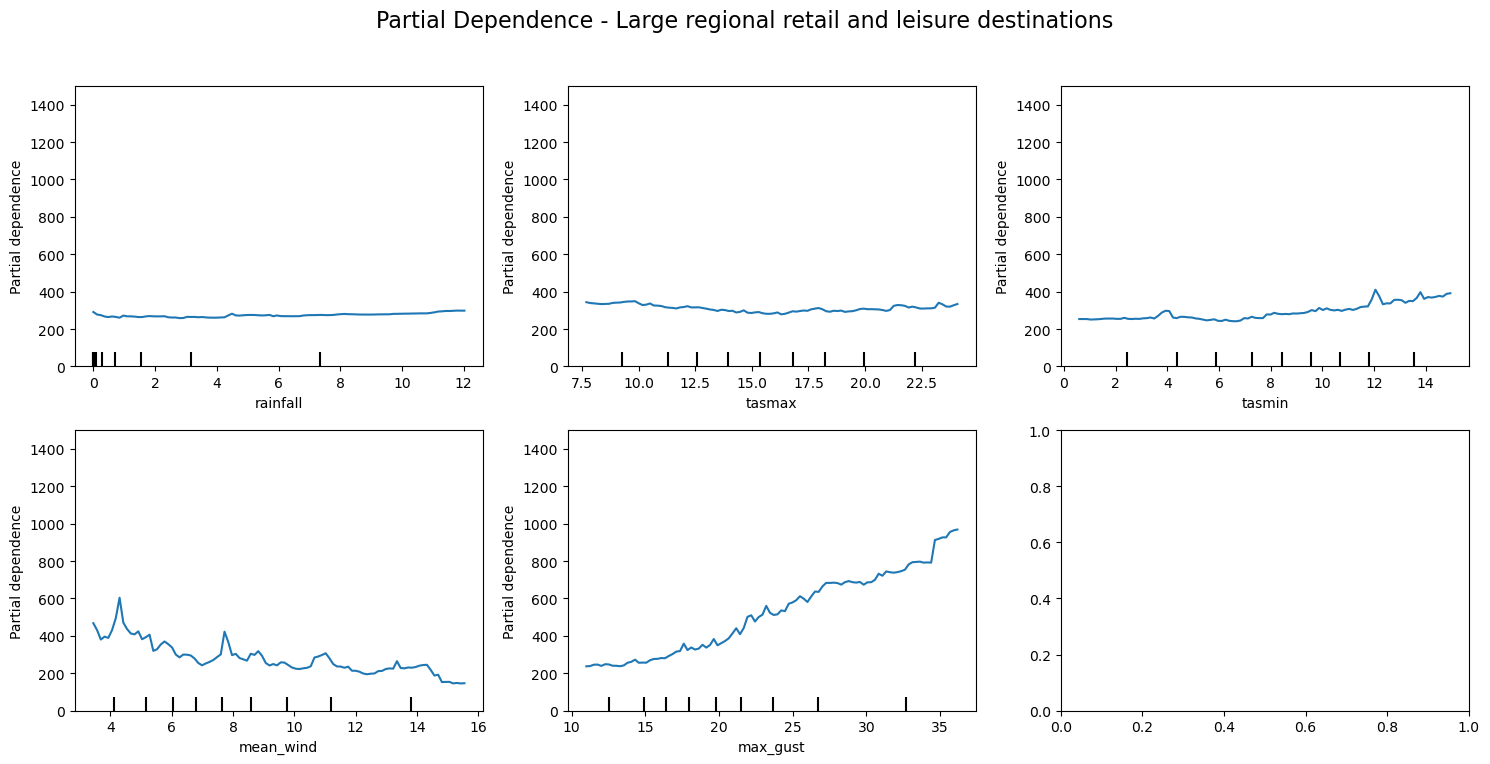

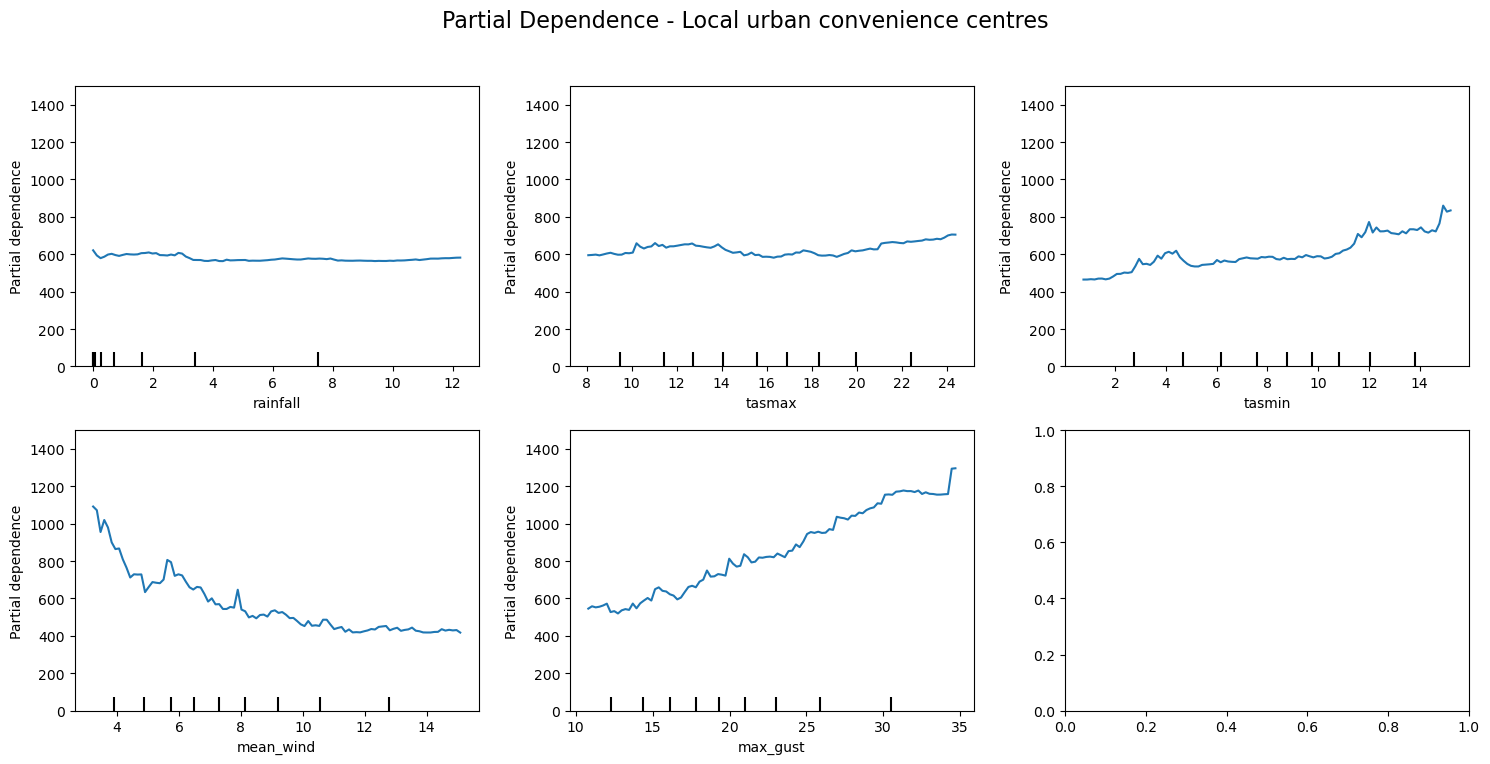

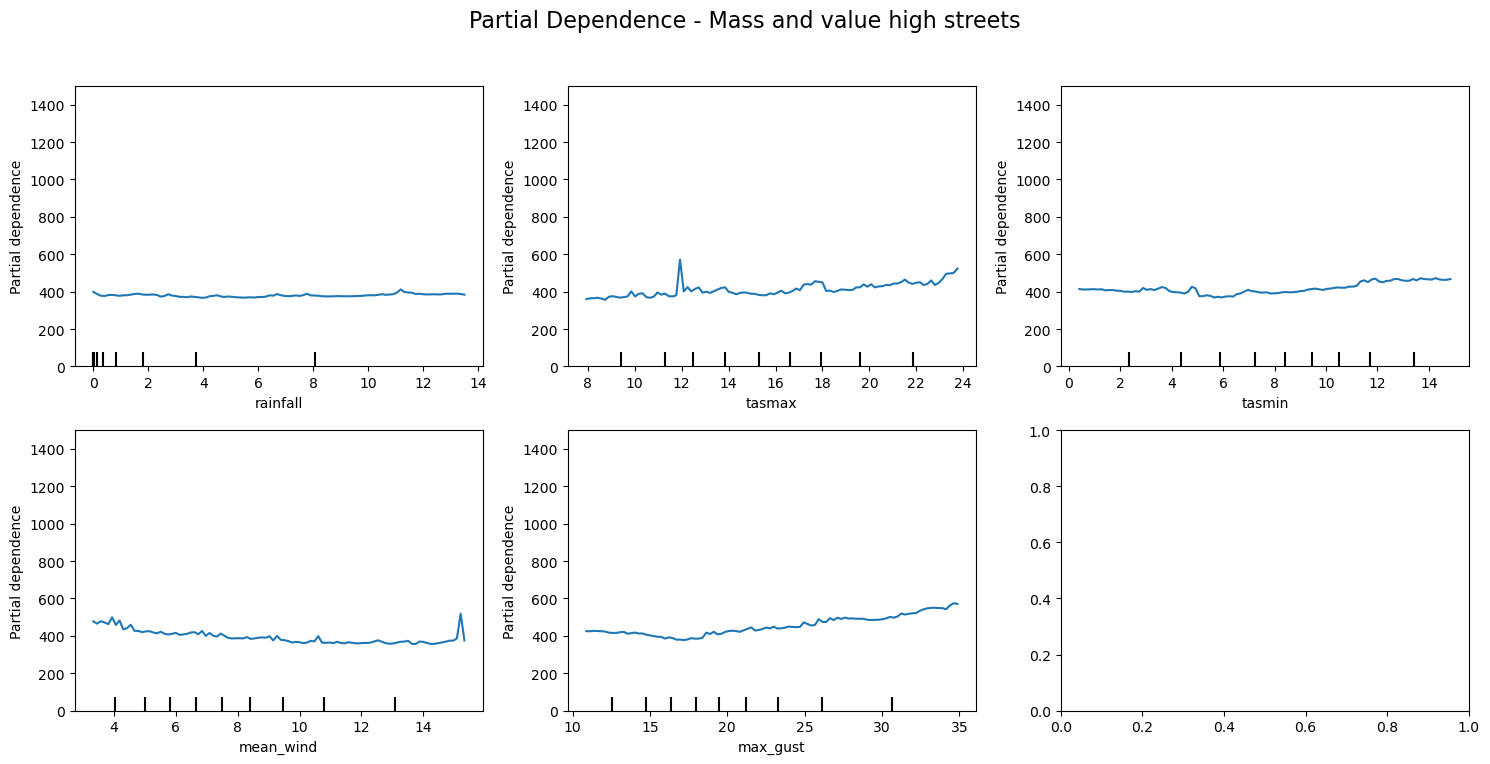

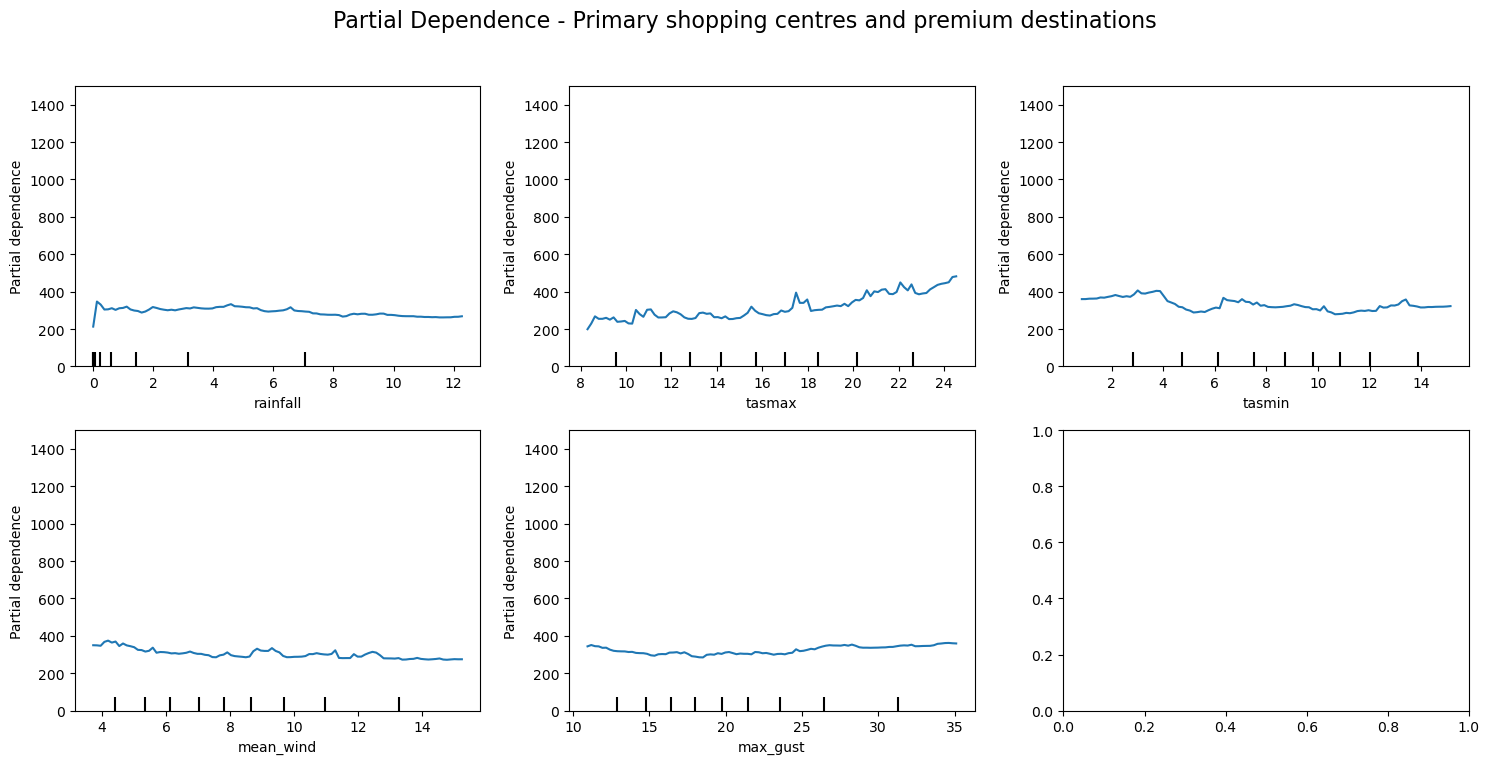

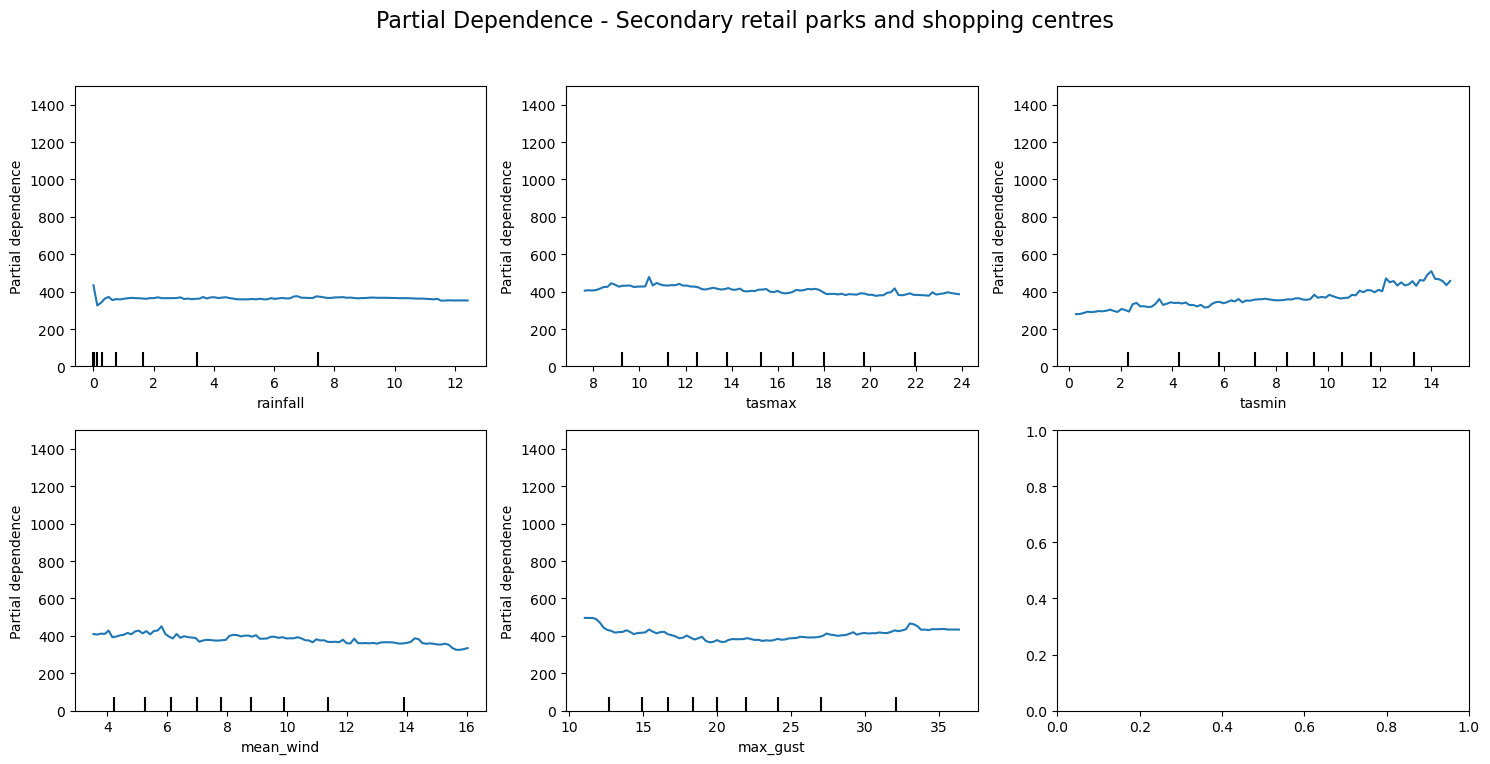

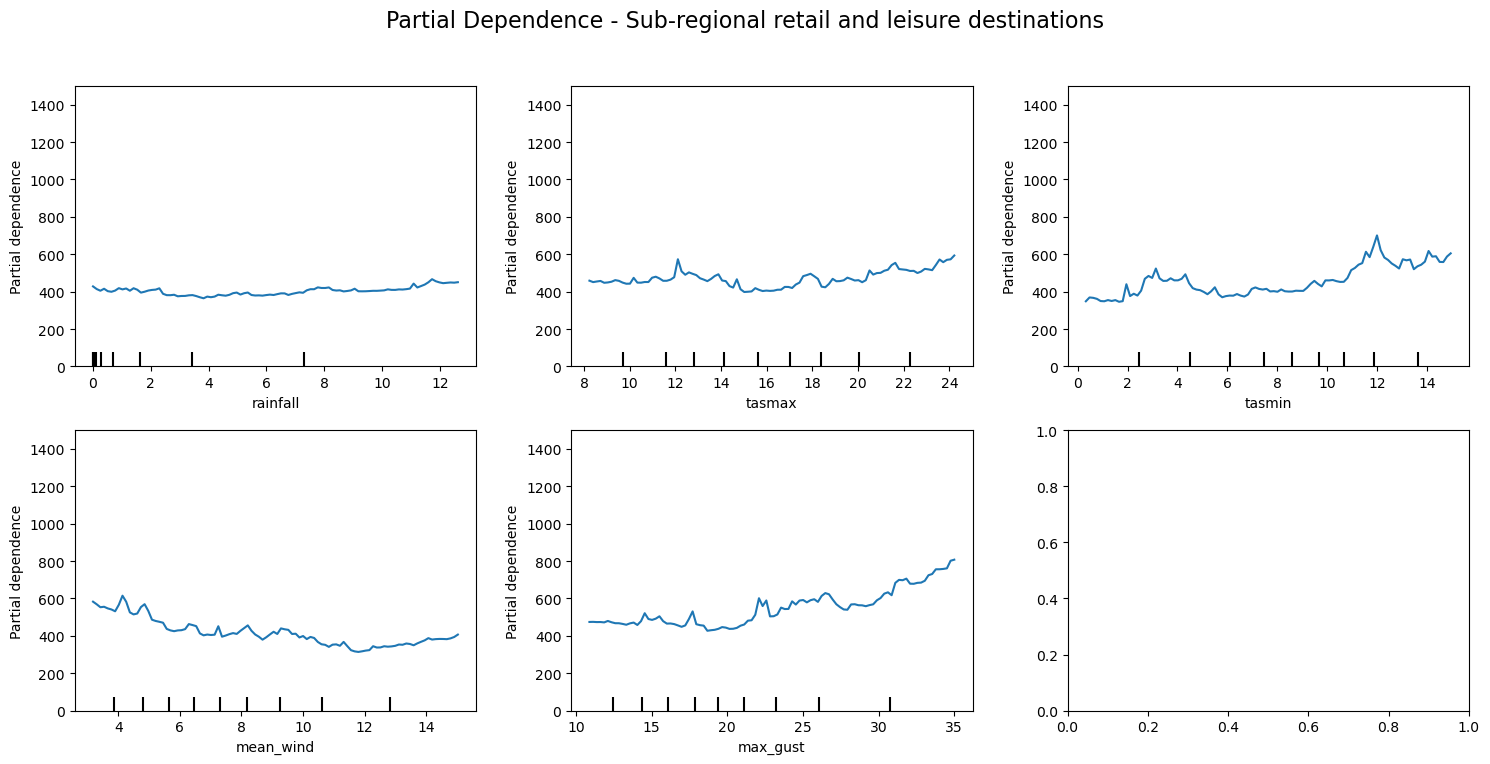

In [ ]:
for name, group_data in df_model2.groupby('groupName'):
    if len(group_data) < 30:
        continue  # skip small groups

    X = group_data[weather_vars].copy()
    y = group_data['events']

    # handle missing values (robustness)
    X = X.fillna(X.median())

    # fit tuned model
    model = RandomForestRegressor(
        random_state=randomState_dt,
        **clf.best_params_
    ).fit(X, y)

    # prepare layout
    n_features = len(weather_vars)
    n_cols = 3
    n_rows = math.ceil(n_features / n_cols)
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    ax = np.atleast_1d(ax).flatten()

    # plot partial dependence
    PartialDependenceDisplay.from_estimator(
        model,
        X,
        features=weather_vars,
        ax=ax[:n_features]
    )

    for axis in ax[:n_features]:
        axis.set_ylim(0, 1500)  # optional: adjust y-limits for interpretability

    plt.suptitle(f'Partial Dependence - {name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### later

Leisure footprint?
rail/tube--- specifically for london?

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + [col for col in df_model.columns 
     if col.startswith('season_')]

# split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(features)

['Residential Population (Weighted Catchment)', 'Tourism Score', 'Retail Footprint Score', 'Leisure_Footprint_Score', 'weekend', 'holiday', 'season_Spring', 'season_Summer', 'season_Winter']


In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical
print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 9)
(241484,)
(60371, 9)
(60371,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=6; total time=  19.1s
[CV] END ..................max_depth=10, min_samples_split=6; total time=  19.6s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.5s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  20.1s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  21.0s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.8s
[CV] END ..................max_depth=10, min_samples_split=2; total time=  20.9s
[CV] END ..................max_depth=10, min_samples_split=4; total time=  20.6s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  20.3s
[CV] END .................max_depth=10, min_samples_split=10; total time=  20.2s
[CV] END ..................max_depth=10, min_samples_split=8; total time=  21.0s
[CV] END .................max_depth=10, min_sam

The best parameter value is: 
{'max_depth': 30, 'min_samples_split': 10}
The best score is: 
0.9352327178310876


Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9420345488227957
R² on the testing data:
0.9371560285731977


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9419959254693462
R² on the testing data:
0.9372226224991707


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
150.9029560827507
RMSE on the testing data:
160.13306162512416


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.148356
Retail Footprint Score                         0.804908
Tourism Score                                  0.609283
Residential Population (Weighted Catchment)    0.441567
season_Spring                                  0.038250
season_Winter                                  0.035061
weekend                                        0.012662
season_Summer                                  0.007854
holiday                                        0.001427


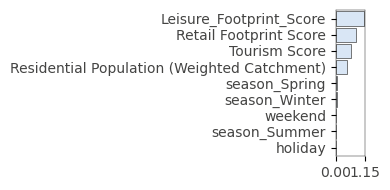

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### 1.2.4. With weather

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 14)
(241484,)
(60371, 14)
(60371,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.5min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=8; total time= 1.5min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.5min
[CV] END .................max_depth=10, min_sam

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.990433920601926
R² on the testing data:
0.9329425347405202


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9714401496366879
R² on the testing data:
0.9344921401195806


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
105.88793045894269
RMSE on the testing data:
163.57846487872388


                                             Importance
Feature                                                
Leisure_Footprint_Score                        1.163618
Retail Footprint Score                         0.681244
Tourism Score                                  0.547773
Residential Population (Weighted Catchment)    0.387151
season_Winter                                  0.032166
season_Spring                                  0.029106
weekend                                        0.011088
season_Summer                                  0.007059
tasmax                                         0.006468
tasmin                                         0.002493
mean_wind                                      0.001779
rainfall                                       0.001670
holiday                                        0.000771
max_gust                                       0.000093


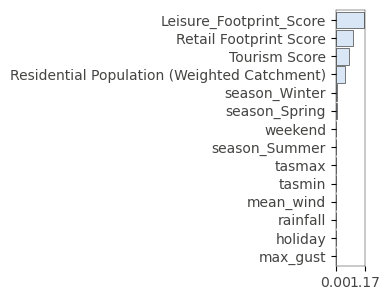

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

#### Add typology

Train/test:

In [ ]:
# define target and features
target = 'events'

# features list
weather_vars = ['rainfall', 'tasmax', 'tasmin', 'mean_wind', 'max_gust']
features = [
    'Residential Population (Weighted Catchment)',
    'Tourism Score',
    'Retail Footprint Score',
    'Leisure_Footprint_Score',
    'weekend',
    'holiday',
] + weather_vars  + [col for col in df_model.columns 
                     if col.startswith('season_') or col.startswith('groupName_')] 

# Split the data into training and testing sets
random_state_split = 100  # for reproducibility

train_x, test_x, train_y, test_y = train_test_split(
    df_model[features],      # predictor variables
    df_model[target],        # target variable
    test_size=0.2,           # 80% train, 20% test
    random_state=random_state_split
)

In [ ]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

(241484, 21)
(241484,)
(60371, 21)
(60371,)
True
True


Hyperparameters:

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'min_samples_split':[2,4,6,8,10]}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters, n_jobs=-1, verbose=2)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=2; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.6min
[CV] END ..................max_depth=10, min_samples_split=4; total time= 1.7min
[CV] END ..................max_depth=10, min_samples_split=6; total time= 1.7min
[CV] END .................max_depth=10, min_samples_split=10; total time= 1.6min
[CV] END ..................max_depth=10, min_sa

Model random forest:

In [ ]:
# not calibrated
rf_final = RandomForestRegressor(random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9905911641982337
R² on the testing data:
0.9336188538725816


In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], 
                                 min_samples_split=clf.best_params_['min_samples_split'], 
                                 random_state=randomState_dt)
rf_final.fit(train_x, train_y)

,n_estimators,100
,criterion,'squared_error'
,max_depth,20
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
print("R² on the training data:")
print(rf_final.score(X=train_x, y=train_y))
print("R² on the testing data:")
print(rf_final.score(X=test_x, y=test_y))

R² on the training data:
0.9712529680814744
R² on the testing data:
0.9350576683784715


In [ ]:
print("RMSE on the training data:")
print(root_mean_squared_error(train_y, rf_final.predict(train_x)))
print("RMSE on the testing data:")
print(root_mean_squared_error(test_y, rf_final.predict(test_x)))

RMSE on the training data:
106.23435905851343
RMSE on the testing data:
162.87084928400242


                                                    Importance
Feature                                                       
Leisure_Footprint_Score                               1.260324
Retail Footprint Score                                0.416413
Tourism Score                                         0.370657
groupName_Indie high streets                          0.287907
Residential Population (Weighted Catchment)           0.160557
season_Winter                                         0.040304
groupName_Local urban convenience centres             0.027065
season_Spring                                         0.025881
groupName_Secondary retail parks and shopping c...    0.022719
weekend                                               0.006561
season_Summer                                         0.005552
tasmax                                                0.004578
groupName_Mass and value high streets                 0.004159
groupName_Primary shopping centres and premium ...    0

/workspace/.conda/lib/python3.11/site-packages/rfpimp.py:52: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


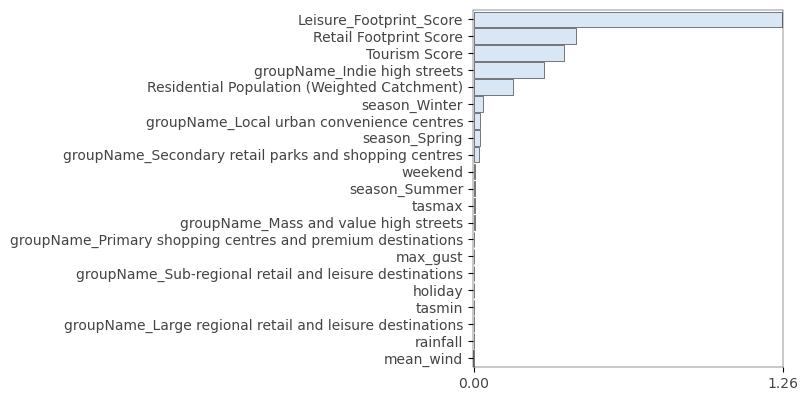

In [ ]:
imp = rfpimp.importances(rf_final, test_x, test_y)
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()